In [2]:
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from scipy.signal import find_peaks, correlate
from IPython.display import HTML
from tqdm import tqdm
import pickle
import matplotlib.cm as cm
import visualisation as vis
from delta_hes_model import *

## Functions

In [3]:
def estimate_amplitude_from_peaks(signal, height=None, distance=None, prominence=None):
    """
    Estimate amplitude by detecting peaks and computing average peak height.

    Parameters:
    - signal: 1D numpy array
    - height, distance, prominence: Optional arguments for peak detection

    Returns:
    - amplitude: Estimated amplitude
    - peak_values: Values of detected peaks
    - trough_values: Values of detected troughs
    """
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-signal, height=height, distance=distance, prominence=prominence)

    peak_values = signal[peaks]
    trough_values = signal[troughs]

    if len(peak_values) == 0 or len(trough_values) == 0:
        return None, peak_values, trough_values  # Not enough data

    avg_peak = np.mean(peak_values)
    avg_trough = np.mean(trough_values)
 
    amplitude = 0.5 * (avg_peak - avg_trough)
    amplitude = np.nan_to_num(amplitude, nan=0.0)  # Handle NaN values
    return amplitude, peak_values, trough_values

def estimate_period_from_peaks(signal, time=None, height=None, distance=None, prominence=None):
    """
    Estimate the period of an oscillating signal using peak detection.

    Parameters:
    - signal: 1D numpy array of the signal values
    - time: Optional 1D array of time values (same length as signal). If None, assume uniform time steps.
    - height, distance, prominence: Optional arguments passed to find_peaks for filtering.

    Returns:
    - period: Estimated average period (float)
    - peak_times: Time values of the detected peaks
    """
    # Find peaks
    peaks, _ = find_peaks(signal, height=height, distance=distance, prominence=prominence)
    if time is None:
        # Assume uniform spacing
        time = np.arange(len(signal))

    peak_times = time[peaks]

    if len(peak_times) < 4:
        period = -1000  # Not enough peaks to estimate period

    # Calculate differences between consecutive peaks
    peak_diffs = np.diff(peak_times)
    period = np.mean(peak_diffs)

    return period, peak_times

## Two cells interacting with each other

### No Hes oscillations, so only coupling

Results: for no hes oscillations we see the expected convergence to lateral inhibition. There is an small effect of pd strength on when we get lateral inhibition. For very low coupling strength we get a state that does not laterally inhibit. Also the hill coefficient makes small changes. But for all parameters the delta difference seems to saturate to a certain value, Hes difference between the cells does grow for larger coupling strengths. 

In [ ]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 0
T_coupling = 0
w_h = 1
w_coupling = 0.2
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0.2, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


In [24]:
num_tsteps = 80000
dt = 0.2
h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)

100%|██████████| 79999/79999 [01:51<00:00, 715.51it/s]


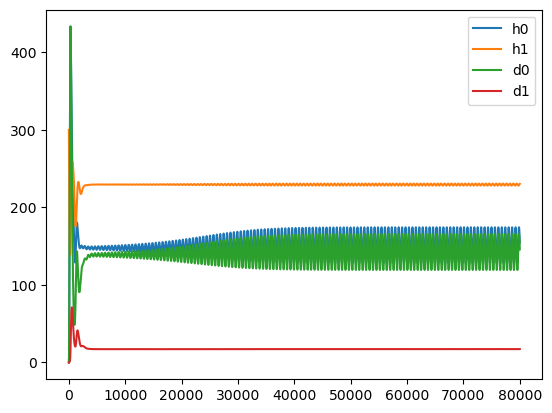

In [25]:
plt.plot(h[:, 0, 0], label='h0')
plt.plot(h[:, 1, 0], label='h1')
plt.plot(d[:, 0, 0], label='d0')
plt.plot(d[:, 1, 0], label='d1')

plt.legend()

In [4]:
time_analysis = 0
h = h[time_analysis:]
m_h = m_h[time_analysis:]   
d = d[time_analysis:]
m_d = m_d[time_analysis:]

In [ ]:
epsilons = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
p_ds = [10, 20, 50, 100]
results_pd = np.zeros((len(p_ds), len(epsilons), num_tsteps, 2, 2))

for i, epsilon in enumerate(epsilons):
    for j, p_d in enumerate(p_ds):
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

        print(i, epsilon, j, p_d)
        
        results_pd[j,i,:,0,0] = h[:,0].flatten()
        results_pd[j,i,:,0,1] = h[:,1].flatten()
        results_pd[j,i,:,1,0] = d[:,0].flatten()
        results_pd[j,i,:,1,1] = d[:,1].flatten()


100%|██████████| 19999/19999 [00:02<00:00, 6709.60it/s]


0 0.02 0 10


100%|██████████| 19999/19999 [00:03<00:00, 6436.70it/s]


0 0.02 1 20


 67%|██████▋   | 13486/19999 [00:01<00:00, 6944.63it/s]


KeyboardInterrupt: 

In [ ]:
epsilons = [0.01, 0.02, 0.03, 0.05, 0.08, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5]
hill_coeffs = [1, 2, 3, 4, 5]
results_n = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))

for i, epsilon in enumerate(epsilons):
    for j, n in enumerate(hill_coeffs):
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

        print(i, epsilon, j, p_d)
        
        results_n[j,i,:,0,0] = h[:,0].flatten()
        results_n[j,i,:,0,1] = h[:,1].flatten()
        results_n[j,i,:,1,0] = d[:,0].flatten()
        results_n[j,i,:,1,1] = d[:,1].flatten()

100%|██████████| 19999/19999 [00:02<00:00, 7159.51it/s]


0 0.01 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8178.39it/s]


0 0.01 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8077.09it/s]


0 0.01 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8277.65it/s]


0 0.01 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7977.70it/s]


0 0.01 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8486.09it/s]


1 0.02 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8249.04it/s]


1 0.02 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8399.15it/s]


1 0.02 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8314.97it/s]


1 0.02 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7742.83it/s]


1 0.02 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8690.37it/s]


2 0.03 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8396.66it/s]


2 0.03 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8273.76it/s]


2 0.03 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8499.62it/s]


2 0.03 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8012.31it/s]


2 0.03 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8721.10it/s]


3 0.05 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8224.22it/s]


3 0.05 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8389.21it/s]


3 0.05 2 100


100%|██████████| 19999/19999 [00:02<00:00, 7819.78it/s]


3 0.05 3 100


100%|██████████| 19999/19999 [00:02<00:00, 6904.06it/s]


3 0.05 4 100


100%|██████████| 19999/19999 [00:02<00:00, 7364.90it/s]


4 0.08 0 100


100%|██████████| 19999/19999 [00:02<00:00, 7076.03it/s]


4 0.08 1 100


100%|██████████| 19999/19999 [00:02<00:00, 7580.83it/s]


4 0.08 2 100


100%|██████████| 19999/19999 [00:02<00:00, 7671.37it/s]


4 0.08 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8282.37it/s]


4 0.08 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8635.87it/s]


5 0.1 0 100


100%|██████████| 19999/19999 [00:02<00:00, 7596.88it/s]


5 0.1 1 100


100%|██████████| 19999/19999 [00:02<00:00, 7864.30it/s]


5 0.1 2 100


100%|██████████| 19999/19999 [00:02<00:00, 7847.55it/s]


5 0.1 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8529.60it/s]


5 0.1 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8575.79it/s]


6 0.0125 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8161.15it/s]


6 0.0125 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8394.42it/s]


6 0.0125 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8219.50it/s]


6 0.0125 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8425.51it/s]


6 0.0125 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8565.75it/s]


7 0.15 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8331.00it/s]


7 0.15 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8338.88it/s]


7 0.15 2 100


100%|██████████| 19999/19999 [00:02<00:00, 7893.17it/s]


7 0.15 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7808.38it/s]


7 0.15 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8491.26it/s]


8 0.175 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8238.95it/s]


8 0.175 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8466.47it/s]


8 0.175 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8301.02it/s]


8 0.175 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7947.97it/s]


8 0.175 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8445.64it/s]


9 0.2 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8519.35it/s]


9 0.2 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8477.68it/s]


9 0.2 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8432.20it/s]


9 0.2 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8211.70it/s]


9 0.2 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8372.98it/s]


10 0.25 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8390.15it/s]


10 0.25 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8285.97it/s]


10 0.25 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8030.03it/s]


10 0.25 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8357.15it/s]


10 0.25 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8656.91it/s]


11 0.3 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8661.84it/s]


11 0.3 1 100


100%|██████████| 19999/19999 [00:02<00:00, 7676.21it/s]


11 0.3 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8270.02it/s]


11 0.3 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8057.94it/s]


11 0.3 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8332.38it/s]


12 0.35 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8392.96it/s]


12 0.35 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8150.52it/s]


12 0.35 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8292.70it/s]


12 0.35 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7820.92it/s]


12 0.35 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8612.54it/s]


13 0.4 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8159.60it/s]


13 0.4 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8508.88it/s]


13 0.4 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8023.32it/s]


13 0.4 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8458.27it/s]


13 0.4 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8352.33it/s]


14 0.45 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8730.66it/s]


14 0.45 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8334.31it/s]


14 0.45 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8274.20it/s]


14 0.45 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7896.34it/s]


14 0.45 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8481.74it/s]


15 0.5 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8483.65it/s]


15 0.5 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8302.48it/s]


15 0.5 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8283.11it/s]


15 0.5 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8010.93it/s]


15 0.5 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8423.71it/s]


16 0.6 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8718.98it/s]


16 0.6 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8103.95it/s]


16 0.6 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8356.64it/s]


16 0.6 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8205.35it/s]


16 0.6 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8486.58it/s]


17 0.7 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8393.38it/s]


17 0.7 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8149.34it/s]


17 0.7 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8190.47it/s]


17 0.7 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8021.25it/s]


17 0.7 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8441.35it/s]


18 0.8 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8487.90it/s]


18 0.8 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8067.75it/s]


18 0.8 2 100


100%|██████████| 19999/19999 [00:02<00:00, 7135.36it/s]


18 0.8 3 100


100%|██████████| 19999/19999 [00:03<00:00, 6657.75it/s]


18 0.8 4 100


100%|██████████| 19999/19999 [00:02<00:00, 7268.48it/s]


19 0.9 0 100


100%|██████████| 19999/19999 [00:02<00:00, 7128.02it/s]


19 0.9 1 100


100%|██████████| 19999/19999 [00:02<00:00, 7792.63it/s]


19 0.9 2 100


100%|██████████| 19999/19999 [00:02<00:00, 7580.02it/s]


19 0.9 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8254.10it/s]


19 0.9 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8202.78it/s]


20 1.0 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8509.06it/s]


20 1.0 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8001.89it/s]


20 1.0 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8396.53it/s]


20 1.0 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7299.00it/s]


20 1.0 4 100


100%|██████████| 19999/19999 [00:02<00:00, 7988.50it/s]


21 1.5 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8471.29it/s]


21 1.5 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8203.27it/s]


21 1.5 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8187.82it/s]


21 1.5 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8390.35it/s]


21 1.5 4 100


100%|██████████| 19999/19999 [00:02<00:00, 7994.83it/s]


22 2.0 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8569.71it/s]


22 2.0 1 100


100%|██████████| 19999/19999 [00:02<00:00, 7892.57it/s]


22 2.0 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8300.46it/s]


22 2.0 3 100


100%|██████████| 19999/19999 [00:02<00:00, 8331.80it/s]


22 2.0 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8338.29it/s]


23 2.5 0 100


100%|██████████| 19999/19999 [00:02<00:00, 8724.84it/s]


23 2.5 1 100


100%|██████████| 19999/19999 [00:02<00:00, 8106.53it/s]


23 2.5 2 100


100%|██████████| 19999/19999 [00:02<00:00, 8270.21it/s]


23 2.5 3 100


100%|██████████| 19999/19999 [00:02<00:00, 7976.03it/s]

23 2.5 4 100


(4, 24)


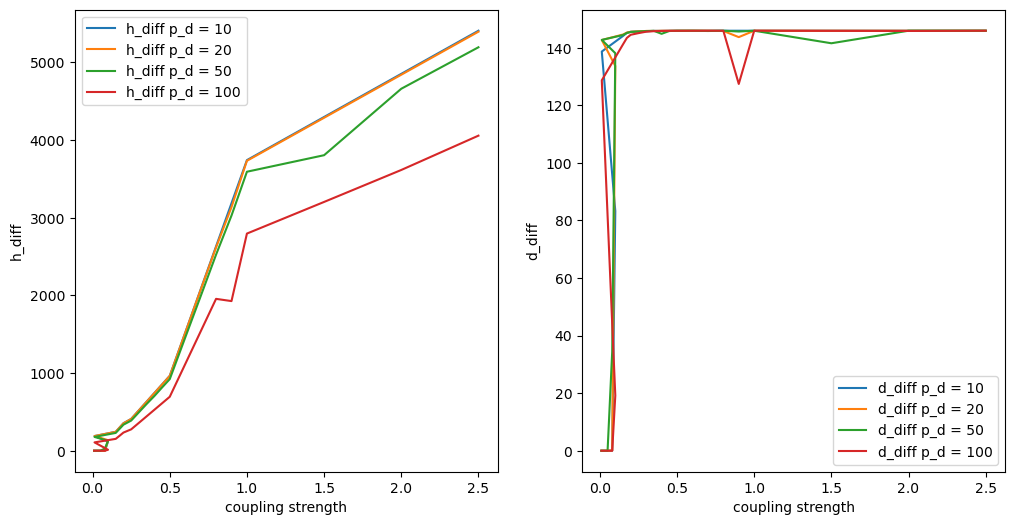

In [90]:
h0_mean = np.mean(results_pd[:,:,  15000:, 0, 0], axis=2)
h1_mean = np.mean(results_pd[:,:, 15000:, 0, 1], axis=2)
d0_mean = np.mean(results_pd[:,:, 15000:, 1, 0], axis=2)
d1_mean = np.mean(results_pd[:,:, 15000:, 1, 1], axis=2)
print(h0_mean.shape)

plt.figure(figsize=(12, 6))
for i in range(len(p_ds)):
    h_diff = np.abs(h0_mean[i] - h1_mean[i])
    d_diff = np.abs(d0_mean[i] - d1_mean[i])
    plt.subplot(1, 2, 1)
    plt.plot(epsilons, h_diff, label='h_diff p_d = {}'.format(p_ds[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('h_diff')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, d_diff, label='d_diff p_d = {}'.format(p_ds[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('d_diff')

plt.legend()


(5, 24)


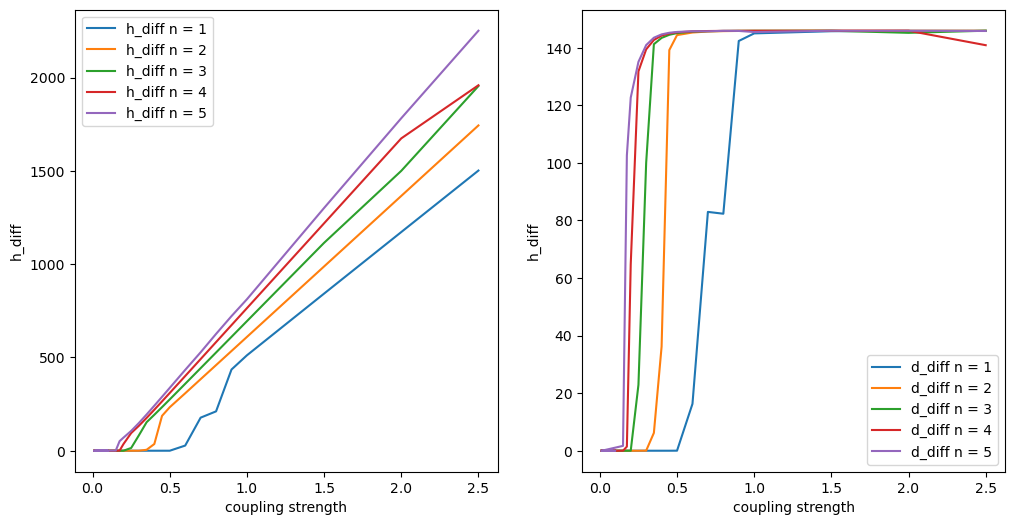

In [ ]:
h0_mean = np.mean(results_n[:,:,  15000:, 0, 0], axis=2)
h1_mean = np.mean(results_n[:,:, 15000:, 0, 1], axis=2)
d0_mean = np.mean(results_n[:,:, 15000:, 1, 0], axis=2)
d1_mean = np.mean(results_n[:,:, 15000:, 1, 1], axis=2)
print(h0_mean.shape)

plt.figure(figsize=(12, 6))
for i in range(len(hill_coeffs)):
    h_diff = np.abs(h0_mean[i] - h1_mean[i])
    d_diff = np.abs(d0_mean[i] - d1_mean[i])
    plt.subplot(1, 2, 1)
    plt.plot(epsilons, h_diff, label='h_diff n = {}'.format(hill_coeffs[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('h_diff')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, d_diff, label='d_diff n = {}'.format(hill_coeffs[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('d_diff')

plt.legend()

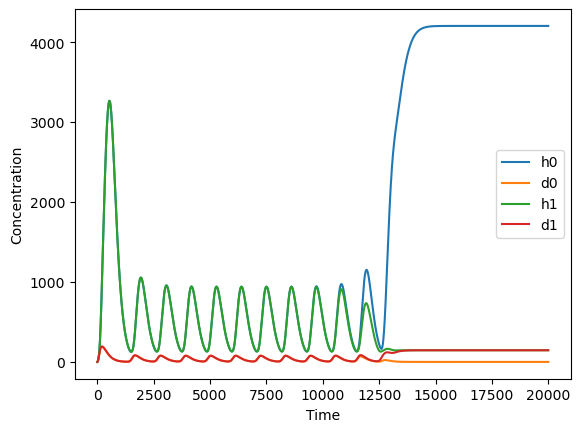

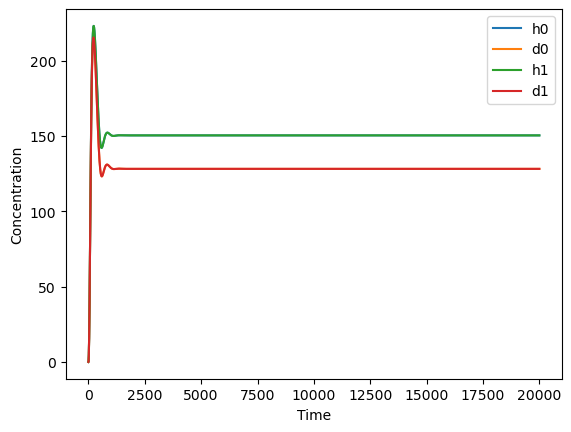

In [85]:
plt.figure()
plt.plot(h[:,0,0], label = 'h0')
plt.plot(d[:,0,0], label = 'd0')
plt.plot(h[:,1,0], label = 'h1')
plt.plot(d[:,1,0], label = 'd1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

plt.figure()
plt.plot(results[0,0,:,0,0], label = 'h0')
plt.plot(results[0,0,:,1,0], label = 'd0')
plt.plot(results[0,0,:,0,1], label = 'h1')
plt.plot(results[0,0,:,1,1], label = 'd1')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

### With Hes oscillations and checkerboard initialisation

Results: Checkerboard initialisation is to force it into it's final lateral inhibited state quickly. Here we see that with Hes oscillations. The oscillations remain even in the laterally inhibited state. The amplitude of the oscillations differ for different coupling strenghts. Again the Delta dynamics seem restrained whereas the Hes dynamics grow for higher coupling strength. 

In [116]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.5
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0.5, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


In [130]:
epsilons = [0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
hill_coeffs = [1,2,3,4,5]

results_checker_n = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))

for i, epsilon in enumerate(epsilons):
    for j,n in enumerate(hill_coeffs):
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='checkerboard', initial_val2=300)

        print(i, epsilon, j, p_d)
        
        results_checker_n[j,i,:,0,0] = h[:,0].flatten()
        results_checker_n[j,i,:,0,1] = h[:,1].flatten()
        results_checker_n[j,i,:,1,0] = d[:,0].flatten()
        results_checker_n[j,i,:,1,1] = d[:,1].flatten()

100%|██████████| 19999/19999 [00:03<00:00, 6236.45it/s]


0 0.02 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5545.67it/s]


0 0.02 1 50


100%|██████████| 19999/19999 [00:03<00:00, 5670.43it/s]


0 0.02 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5664.17it/s]


0 0.02 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6198.77it/s]


0 0.02 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5685.65it/s]


1 0.05 0 50


100%|██████████| 19999/19999 [00:03<00:00, 6557.25it/s]


1 0.05 1 50


100%|██████████| 19999/19999 [00:02<00:00, 6686.79it/s]


1 0.05 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6311.24it/s]


1 0.05 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6350.24it/s]


1 0.05 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5348.44it/s]


2 0.1 0 50


100%|██████████| 19999/19999 [00:03<00:00, 6411.81it/s]


2 0.1 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6008.97it/s]


2 0.1 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5246.76it/s]


2 0.1 3 50


100%|██████████| 19999/19999 [00:03<00:00, 5416.02it/s]


2 0.1 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5638.15it/s]


3 0.15 0 50


100%|██████████| 19999/19999 [00:03<00:00, 6318.32it/s]


3 0.15 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6593.05it/s]


3 0.15 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6633.03it/s]


3 0.15 3 50


100%|██████████| 19999/19999 [00:02<00:00, 6742.68it/s]


3 0.15 4 50


100%|██████████| 19999/19999 [00:02<00:00, 6858.92it/s]


4 0.2 0 50


100%|██████████| 19999/19999 [00:02<00:00, 6670.46it/s]


4 0.2 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6629.28it/s]


4 0.2 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5897.17it/s]


4 0.2 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6240.64it/s]


4 0.2 4 50


100%|██████████| 19999/19999 [00:02<00:00, 6990.94it/s]


5 0.25 0 50


100%|██████████| 19999/19999 [00:03<00:00, 6150.62it/s]


5 0.25 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6536.97it/s]


5 0.25 2 50


100%|██████████| 19999/19999 [00:02<00:00, 8090.80it/s]


5 0.25 3 50


100%|██████████| 19999/19999 [00:02<00:00, 8054.10it/s]


5 0.25 4 50


100%|██████████| 19999/19999 [00:02<00:00, 8114.31it/s]


6 0.3 0 50


100%|██████████| 19999/19999 [00:02<00:00, 6844.83it/s]


6 0.3 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6405.74it/s]


6 0.3 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6028.56it/s]


6 0.3 3 50


100%|██████████| 19999/19999 [00:03<00:00, 5610.58it/s]


6 0.3 4 50


100%|██████████| 19999/19999 [00:03<00:00, 6049.53it/s]


7 0.35 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5537.50it/s]


7 0.35 1 50


100%|██████████| 19999/19999 [00:03<00:00, 5838.11it/s]


7 0.35 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5887.63it/s]


7 0.35 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6435.48it/s]


7 0.35 4 50


100%|██████████| 19999/19999 [00:03<00:00, 6530.39it/s]


8 0.4 0 50


100%|██████████| 19999/19999 [00:02<00:00, 6668.91it/s]


8 0.4 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6537.97it/s]


8 0.4 2 50


100%|██████████| 19999/19999 [00:02<00:00, 6790.00it/s]


8 0.4 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6521.67it/s]


8 0.4 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5759.28it/s]


9 0.45 0 50


100%|██████████| 19999/19999 [00:03<00:00, 6080.79it/s]


9 0.45 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6181.06it/s]


9 0.45 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5177.66it/s]


9 0.45 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4986.43it/s]


9 0.45 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4453.54it/s]


10 0.5 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5872.47it/s]


10 0.5 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6526.80it/s]


10 0.5 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6569.30it/s]


10 0.5 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6241.78it/s]


10 0.5 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4863.68it/s]


11 0.6 0 50


100%|██████████| 19999/19999 [00:04<00:00, 4054.44it/s]


11 0.6 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6003.05it/s]


11 0.6 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5883.28it/s]


11 0.6 3 50


100%|██████████| 19999/19999 [00:03<00:00, 5731.97it/s]


11 0.6 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5600.17it/s]


12 0.7 0 50


100%|██████████| 19999/19999 [00:04<00:00, 4132.19it/s]


12 0.7 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6340.32it/s]


12 0.7 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6307.54it/s]


12 0.7 3 50


100%|██████████| 19999/19999 [00:03<00:00, 6589.48it/s]


12 0.7 4 50


100%|██████████| 19999/19999 [00:03<00:00, 6339.90it/s]


13 0.8 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5114.78it/s]


13 0.8 1 50


100%|██████████| 19999/19999 [00:05<00:00, 3938.89it/s]


13 0.8 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5214.31it/s]


13 0.8 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4213.16it/s]


13 0.8 4 50


100%|██████████| 19999/19999 [00:05<00:00, 3925.59it/s]


14 0.9 0 50


100%|██████████| 19999/19999 [00:04<00:00, 4726.71it/s]


14 0.9 1 50


100%|██████████| 19999/19999 [00:04<00:00, 4517.43it/s]


14 0.9 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5513.09it/s]


14 0.9 3 50


100%|██████████| 19999/19999 [00:05<00:00, 3974.19it/s]


14 0.9 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4308.31it/s]


15 1.0 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5203.98it/s]


15 1.0 1 50


100%|██████████| 19999/19999 [00:03<00:00, 5575.93it/s]


15 1.0 2 50


100%|██████████| 19999/19999 [00:04<00:00, 4666.32it/s]


15 1.0 3 50


100%|██████████| 19999/19999 [00:03<00:00, 5157.64it/s]


15 1.0 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4703.84it/s]


16 1.5 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5495.34it/s]


16 1.5 1 50


100%|██████████| 19999/19999 [00:04<00:00, 4380.36it/s]


16 1.5 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5808.69it/s]


16 1.5 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4835.77it/s]


16 1.5 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5328.60it/s]


17 2.0 0 50


100%|██████████| 19999/19999 [00:05<00:00, 3604.22it/s]


17 2.0 1 50


100%|██████████| 19999/19999 [00:04<00:00, 4466.00it/s]


17 2.0 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6119.43it/s]


17 2.0 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4961.75it/s]


17 2.0 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4335.95it/s]


18 2.5 0 50


100%|██████████| 19999/19999 [00:04<00:00, 4768.62it/s]


18 2.5 1 50


100%|██████████| 19999/19999 [00:04<00:00, 4159.57it/s]


18 2.5 2 50


100%|██████████| 19999/19999 [00:04<00:00, 4038.01it/s]


18 2.5 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4312.09it/s]


18 2.5 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4384.84it/s]


19 3.0 0 50


100%|██████████| 19999/19999 [00:03<00:00, 6150.68it/s]


19 3.0 1 50


100%|██████████| 19999/19999 [00:03<00:00, 6244.73it/s]


19 3.0 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5057.63it/s]


19 3.0 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4949.39it/s]


19 3.0 4 50


100%|██████████| 19999/19999 [00:03<00:00, 5790.49it/s]


20 3.5 0 50


100%|██████████| 19999/19999 [00:05<00:00, 3924.65it/s]


20 3.5 1 50


100%|██████████| 19999/19999 [00:03<00:00, 5394.25it/s]


20 3.5 2 50


100%|██████████| 19999/19999 [00:05<00:00, 3777.44it/s]


20 3.5 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4796.81it/s]


20 3.5 4 50


100%|██████████| 19999/19999 [00:03<00:00, 6077.64it/s]


21 4.0 0 50


100%|██████████| 19999/19999 [00:03<00:00, 5464.49it/s]


21 4.0 1 50


100%|██████████| 19999/19999 [00:03<00:00, 5582.37it/s]


21 4.0 2 50


100%|██████████| 19999/19999 [00:03<00:00, 5807.22it/s]


21 4.0 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4419.13it/s]


21 4.0 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4218.47it/s]


22 4.5 0 50


100%|██████████| 19999/19999 [00:05<00:00, 3888.46it/s]


22 4.5 1 50


100%|██████████| 19999/19999 [00:05<00:00, 3493.04it/s]


22 4.5 2 50


100%|██████████| 19999/19999 [00:04<00:00, 4419.63it/s]


22 4.5 3 50


100%|██████████| 19999/19999 [00:04<00:00, 4995.21it/s]


22 4.5 4 50


100%|██████████| 19999/19999 [00:04<00:00, 4581.25it/s]


23 5.0 0 50


100%|██████████| 19999/19999 [00:02<00:00, 6771.16it/s]


23 5.0 1 50


100%|██████████| 19999/19999 [00:04<00:00, 4809.75it/s]


23 5.0 2 50


100%|██████████| 19999/19999 [00:04<00:00, 4108.09it/s]


23 5.0 3 50


100%|██████████| 19999/19999 [00:03<00:00, 5399.87it/s]

23 5.0 4 50


In [ ]:
# calculating the mean of the results
time_start = 10000

h0 = results_checker_n[:,:,  time_start:, 0, 0]
h1 = results_checker_n[:,:,  time_start:, 0, 1]
d0 = results_checker_n[:,:,  time_start:, 1, 0]
d1 = results_checker_n[:,:,  time_start:, 1, 1]

h0_mean = np.mean(h0, axis=2)
h1_mean = np.mean(h1, axis=2)
d0_mean = np.mean(d0, axis=2)
d1_mean = np.mean(d1, axis=2)

h_diff = np.abs(h0_mean - h1_mean)
d_diff = np.abs(d0_mean - d1_mean)

period_h0 = np.zeros((len(hill_coeffs), len(epsilons)))
period_d0 = np.zeros((len(hill_coeffs), len(epsilons)))
period_h1 = np.zeros((len(hill_coeffs), len(epsilons)))
period_d1 = np.zeros((len(hill_coeffs), len(epsilons)))

amplitude_h0 = np.zeros((len(hill_coeffs), len(epsilons)))
amplitude_d0 = np.zeros((len(hill_coeffs), len(epsilons)))
amplitude_h1 = np.zeros((len(hill_coeffs), len(epsilons)))
amplitude_d1 = np.zeros((len(hill_coeffs), len(epsilons)))

for i in range(len(epsilons)):
    for j in range(len(hill_coeffs)):
        period_h0[j,i] = estimate_period_from_peaks(h0[j,i,:], time=np.arange(num_tsteps - time_start)*dt, height=None, distance=None, prominence=None)[0]
        period_d0[j,i] = estimate_period_from_peaks(d0[j,i,:], time=np.arange(num_tsteps - time_start)*dt, height=None, distance=None, prominence=None)[0]
        period_h1[j,i] = estimate_period_from_peaks(h1[j,i,:], time=np.arange(num_tsteps - time_start)*dt, height=None, distance=None, prominence=None)[0]
        period_d1[j,i] = estimate_period_from_peaks(d1[j,i,:], time=np.arange(num_tsteps - time_start)*dt, height=None, distance=None, prominence=None)[0]

        amplitude_h0[j,i] = estimate_amplitude_from_peaks(h0[j,i,:], height=None, distance=None, prominence=None)[0]
        amplitude_d0[j,i] = estimate_amplitude_from_peaks(d0[j,i,:], height=None, distance=None, prominence=None)[0]
        amplitude_h1[j,i] = estimate_amplitude_from_peaks(h1[j,i,:], height=None, distance=None, prominence=None)[0]
        amplitude_d1[j,i] = estimate_amplitude_from_peaks(d1[j,i,:], height=None, distance=None, prominence=None)[0]



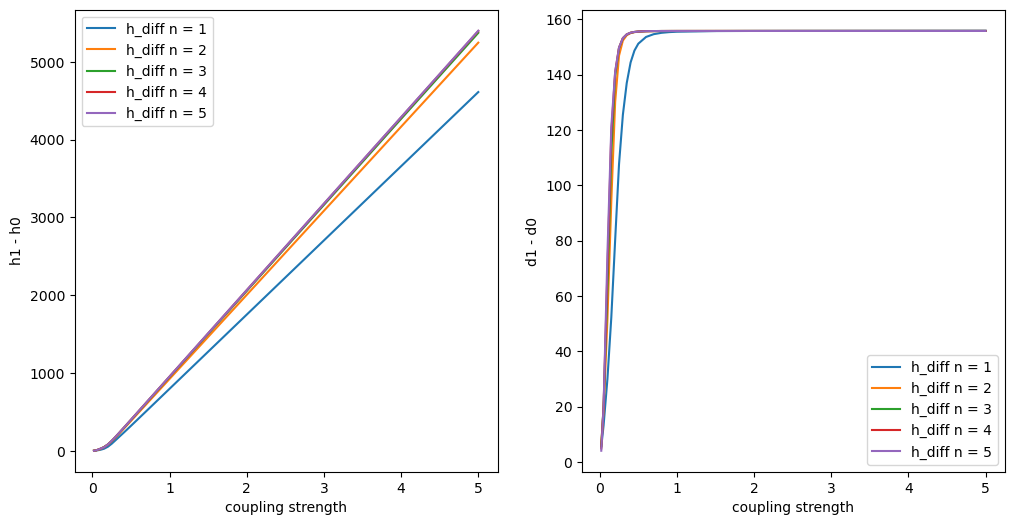

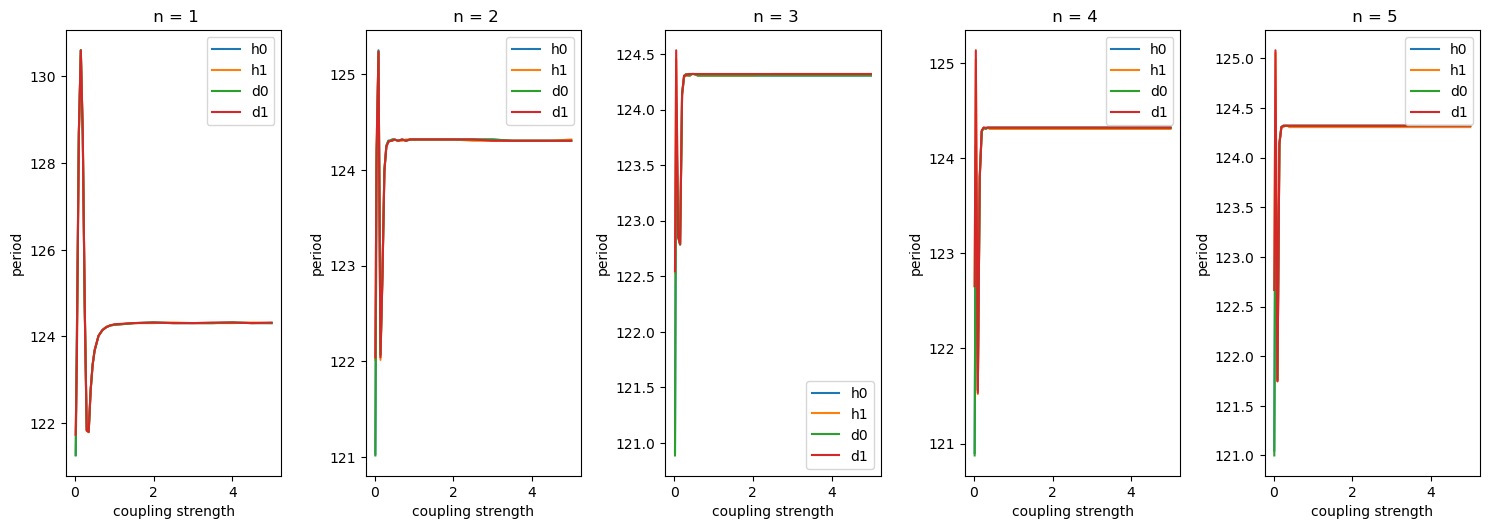

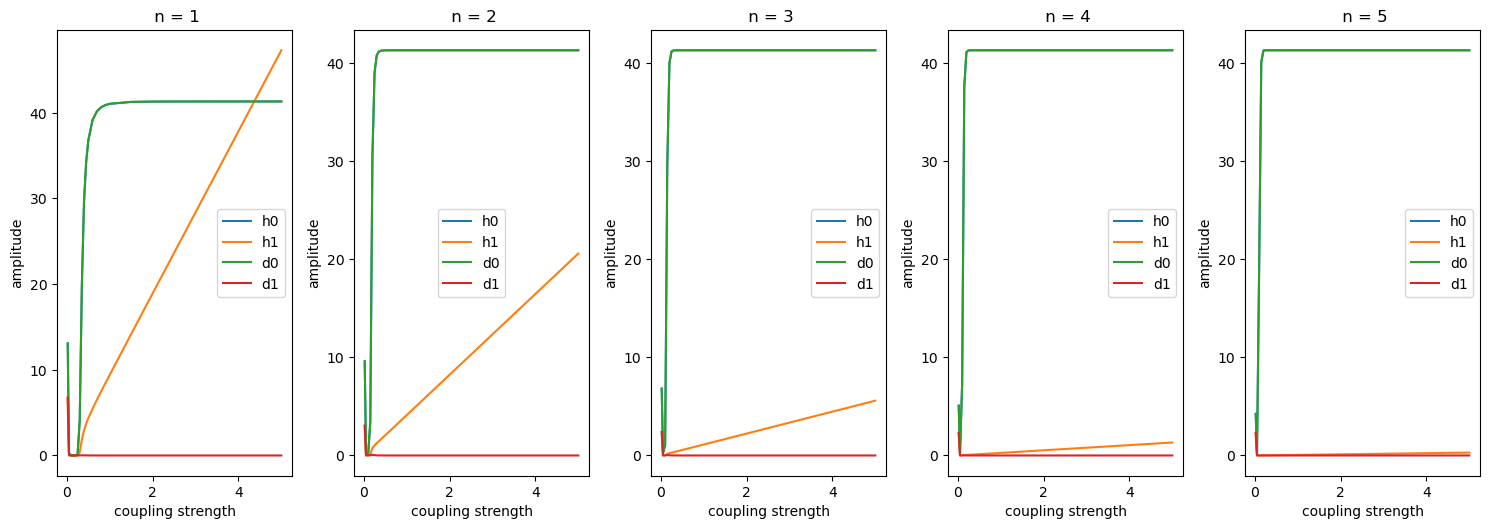

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, h_diff[i], label='h_diff n = {}'.format(hill_coeffs[i]))
plt.xlabel('coupling strength')
plt.ylabel('h1 - h0')   
plt.legend()

plt.subplot(1, 2, 2)
for i in range(len(hill_coeffs)):
    plt.plot(epsilons, d_diff[i], label='h_diff n = {}'.format(hill_coeffs[i]))
plt.xlabel('coupling strength')
plt.ylabel('d1 - d0')   
plt.legend()
plt.show()

plt.figure(figsize=(15, 10))
for i in range(len(hill_coeffs)):
    plt.subplot(2, 5, i+1)
    plt.plot(epsilons, period_h0[i], label='h0')
    plt.plot(epsilons, period_h1[i], label='h1')
    plt.plot(epsilons, period_d0[i], label='d0')
    plt.plot(epsilons, period_d1[i], label='d1')

    plt.title(' n = {}'.format(hill_coeffs[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('period')   
    plt.legend()
    plt.tight_layout()

plt.figure(figsize=(15, 10))

for i in range(len(hill_coeffs)):
    plt.subplot(2, 5, i+1)
    plt.plot(epsilons, amplitude_h0[i], label='h0')
    plt.plot(epsilons, amplitude_h1[i], label='h1')
    plt.plot(epsilons, amplitude_d0[i], label='d0')
    plt.plot(epsilons, amplitude_d1[i], label='d1')

    plt.title(' n = {}'.format(hill_coeffs[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('amplitude')   
    plt.legend()
    plt.tight_layout()

In [1]:
plt.plot(results_checker_n[0,0,:,0,0], label = 'h0')

NameError: name 'plt' is not defined

### With Hes and uniform initialisation

Want to see when the system goes into lateral inhibition and see the properties of the system before it laterally inhibits. 

The system doesn't work nicely for very low p_d (p_d = 10) and for n = 1.

In [33]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.2
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

num_tsteps = 20000
dt = 0.2

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20.]), T_coupling=array([0., 0.]), w_h=1, w_coupling=0.2, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


In [34]:
epsilons = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5]
hill_coeffs = [1, 2, 3, 4, 5]
results_hes_n = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps, 2, 2))
p_d = 50

for i, epsilon in enumerate(epsilons):
    for j, n in enumerate(hill_coeffs):
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

        print(i, epsilon, j, n)
        
        results_hes_n[j,i,:,0,0] = h[:,0].flatten()
        results_hes_n[j,i,:,0,1] = h[:,1].flatten()
        results_hes_n[j,i,:,1,0] = d[:,0].flatten()
        results_hes_n[j,i,:,1,1] = d[:,1].flatten()

100%|██████████| 19999/19999 [00:04<00:00, 4640.84it/s]


0 0.01 0 1


100%|██████████| 19999/19999 [00:03<00:00, 5353.78it/s]


0 0.01 1 2


100%|██████████| 19999/19999 [00:03<00:00, 6424.26it/s]


0 0.01 2 3


100%|██████████| 19999/19999 [00:02<00:00, 7116.69it/s]


0 0.01 3 4


100%|██████████| 19999/19999 [00:02<00:00, 7539.28it/s]


0 0.01 4 5


100%|██████████| 19999/19999 [00:02<00:00, 8529.37it/s] 


1 0.02 0 1


100%|██████████| 19999/19999 [00:01<00:00, 10133.31it/s]


1 0.02 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9520.19it/s]


1 0.02 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9250.79it/s]


1 0.02 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9300.86it/s]


1 0.02 4 5


100%|██████████| 19999/19999 [00:02<00:00, 8458.33it/s]


2 0.05 0 1


100%|██████████| 19999/19999 [00:02<00:00, 8220.68it/s]


2 0.05 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9331.22it/s]


2 0.05 2 3


100%|██████████| 19999/19999 [00:02<00:00, 8759.72it/s]


2 0.05 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9538.81it/s]


2 0.05 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9347.05it/s]


3 0.1 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9580.51it/s]


3 0.1 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9148.50it/s]


3 0.1 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9100.91it/s]


3 0.1 3 4


100%|██████████| 19999/19999 [00:02<00:00, 8965.97it/s]


3 0.1 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9434.39it/s]


4 0.15 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9448.44it/s]


4 0.15 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9150.30it/s]


4 0.15 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9052.15it/s]


4 0.15 3 4


100%|██████████| 19999/19999 [00:02<00:00, 8879.62it/s]


4 0.15 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9536.28it/s]


5 0.2 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9781.76it/s]


5 0.2 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9096.70it/s]


5 0.2 2 3


100%|██████████| 19999/19999 [00:02<00:00, 8779.56it/s]


5 0.2 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9163.04it/s]


5 0.2 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9620.54it/s]


6 0.25 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9442.21it/s]


6 0.25 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9077.97it/s]


6 0.25 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9256.71it/s]


6 0.25 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9297.97it/s]


6 0.25 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9419.57it/s]


7 0.3 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9484.55it/s]


7 0.3 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9436.93it/s]


7 0.3 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9365.05it/s]


7 0.3 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9219.99it/s]


7 0.3 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9585.77it/s]


8 0.35 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9737.19it/s] 


8 0.35 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9274.24it/s]


8 0.35 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9292.73it/s]


8 0.35 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9790.94it/s]


8 0.35 4 5


100%|██████████| 19999/19999 [00:02<00:00, 8969.99it/s]


9 0.4 0 1


100%|██████████| 19999/19999 [00:02<00:00, 8460.01it/s]


9 0.4 1 2


100%|██████████| 19999/19999 [00:02<00:00, 7798.37it/s]


9 0.4 2 3


100%|██████████| 19999/19999 [00:02<00:00, 8287.21it/s]


9 0.4 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9379.10it/s]


9 0.4 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9780.98it/s] 


10 0.45 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9760.90it/s]


10 0.45 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9635.79it/s]


10 0.45 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9613.70it/s]


10 0.45 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9325.15it/s]


10 0.45 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9445.51it/s]


11 0.5 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9537.19it/s]


11 0.5 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9230.78it/s]


11 0.5 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9544.46it/s]


11 0.5 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9319.26it/s]


11 0.5 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9513.06it/s]


12 0.6 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9422.07it/s]


12 0.6 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9785.98it/s]


12 0.6 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9660.30it/s]


12 0.6 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9574.18it/s]


12 0.6 4 5


100%|██████████| 19999/19999 [00:01<00:00, 10082.92it/s]


13 0.7 0 1


100%|██████████| 19999/19999 [00:01<00:00, 10113.41it/s]


13 0.7 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9746.23it/s]


13 0.7 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9705.56it/s]


13 0.7 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9767.75it/s]


13 0.7 4 5


100%|██████████| 19999/19999 [00:01<00:00, 10031.07it/s]


14 0.8 0 1


100%|██████████| 19999/19999 [00:01<00:00, 10083.25it/s]


14 0.8 1 2


100%|██████████| 19999/19999 [00:02<00:00, 9718.98it/s]


14 0.8 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9661.62it/s]


14 0.8 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9823.46it/s]


14 0.8 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9591.99it/s]


15 0.9 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9675.79it/s] 


15 0.9 1 2


100%|██████████| 19999/19999 [00:02<00:00, 8747.75it/s]


15 0.9 2 3


100%|██████████| 19999/19999 [00:02<00:00, 8937.85it/s]


15 0.9 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9148.63it/s]


15 0.9 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9343.13it/s]


16 1.0 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9613.41it/s]


16 1.0 1 2


100%|██████████| 19999/19999 [00:02<00:00, 8310.53it/s]


16 1.0 2 3


100%|██████████| 19999/19999 [00:02<00:00, 8140.95it/s]


16 1.0 3 4


100%|██████████| 19999/19999 [00:02<00:00, 7904.59it/s]


16 1.0 4 5


100%|██████████| 19999/19999 [00:02<00:00, 8947.41it/s]


17 1.5 0 1


100%|██████████| 19999/19999 [00:02<00:00, 8898.78it/s]


17 1.5 1 2


100%|██████████| 19999/19999 [00:02<00:00, 8917.00it/s]


17 1.5 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9162.20it/s]


17 1.5 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9657.95it/s]


17 1.5 4 5


100%|██████████| 19999/19999 [00:01<00:00, 10001.78it/s]


18 2.0 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9530.28it/s] 


18 2.0 1 2


100%|██████████| 19999/19999 [00:02<00:00, 8991.10it/s]


18 2.0 2 3


100%|██████████| 19999/19999 [00:02<00:00, 9262.49it/s]


18 2.0 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9232.63it/s]


18 2.0 4 5


100%|██████████| 19999/19999 [00:02<00:00, 9360.30it/s]


19 2.5 0 1


100%|██████████| 19999/19999 [00:02<00:00, 9526.57it/s]


19 2.5 1 2


100%|██████████| 19999/19999 [00:02<00:00, 8884.71it/s]


19 2.5 2 3


100%|██████████| 19999/19999 [00:02<00:00, 8928.92it/s]


19 2.5 3 4


100%|██████████| 19999/19999 [00:02<00:00, 9188.07it/s]

19 2.5 4 5


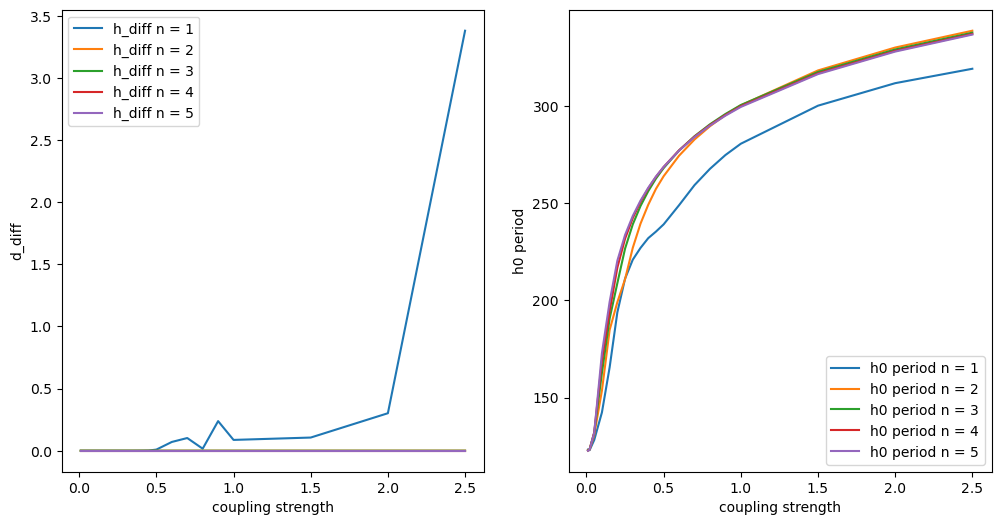

In [41]:
time_start = 2000

h_diff = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps-time_start))
d_diff = np.zeros((len(hill_coeffs), len(epsilons), num_tsteps-time_start))
h_diff_mean = np.zeros((len(hill_coeffs), len(epsilons)))
d_diff_mean = np.zeros((len(hill_coeffs), len(epsilons)))
period_h0 = np.zeros((len(hill_coeffs), len(epsilons)))
period_h1 = np.zeros((len(hill_coeffs), len(epsilons)))
period_d0 = np.zeros((len(hill_coeffs), len(epsilons)))
period_d1 = np.zeros((len(hill_coeffs), len(epsilons)))

plt.figure(figsize=(12, 6))
for i in range(len(hill_coeffs)):
    for j in range(len(epsilons)):
        h0 = results_hes_n[i,j,time_start:,0,0]
        h1 = results_hes_n[i,j,time_start:,0,1]
        d0 = results_hes_n[i,j,time_start:,1,0] 
        d1 = results_hes_n[i,j,time_start:,1,1]

        h_diff[i,j] = np.abs(h0 - h1)
        d_diff[i,j] = np.abs(d0 - d1)

        h_diff_mean[i,j] = np.mean(h_diff[i,j])
        d_diff_mean[i,j] = np.mean(d_diff[i,j])

        period_h0[i,j] = estimate_period_from_peaks(h0, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_h1[i,j] = estimate_period_from_peaks(h1, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_d0[i,j] = estimate_period_from_peaks(d0, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_d1[i,j] = estimate_period_from_peaks(d1, time = np.arange(num_tsteps-time_start)*dt)[0]

    plt.subplot(1, 2, 1)
    plt.plot(epsilons, d_diff_mean[i,:], label='h_diff n = {}'.format(hill_coeffs[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('d_diff')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, period_h0[i,:], label='h0 period n = {}'.format(hill_coeffs[i]))
    # plt.plot(epsilons, period_h1[i,:], label='h1 period n = {}'.format(hill_coeffs[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('h0 period')
    plt.legend()



### When does it laterally inhibit? 

20


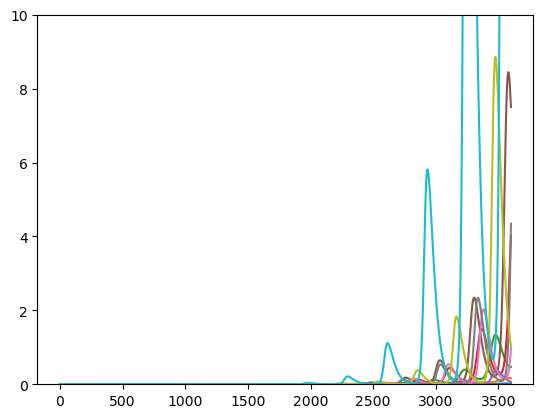

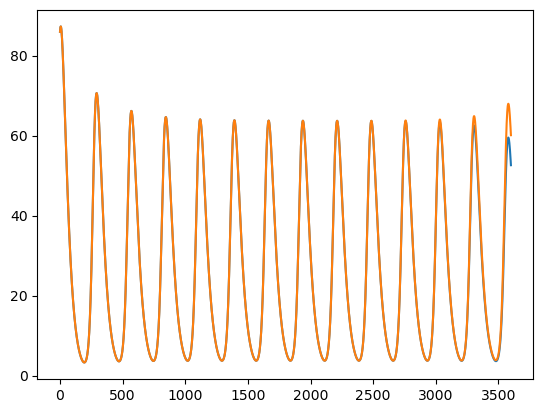

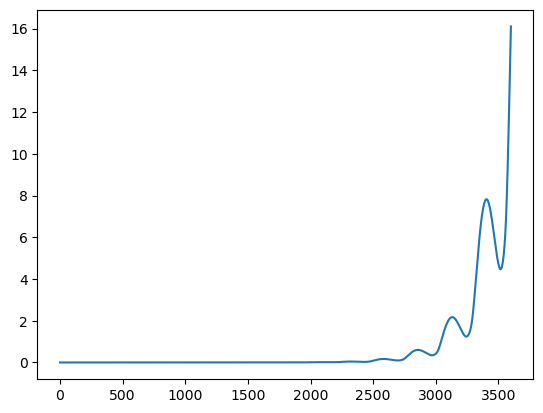

In [59]:
diffs = np.zeros((len(hill_coeffs), len(epsilons)))
print(len(epsilons))
for i in range(1):
    for j in range(len(epsilons)):
        
        plt.plot(np.arange(num_tsteps-time_start)*dt, d_diff[i,j], label='h_diff n = {}'.format(hill_coeffs[i]))
        plt.ylim(0,10)

plt.figure()
plt.plot(np.arange(num_tsteps-time_start)*dt, results_hes_n[0,15,time_start:,1,0], label = 'h0')
plt.plot(np.arange(num_tsteps-time_start)*dt, results_hes_n[0,15,time_start:,1,1], label = 'h1')

plt.figure()
plt.plot(np.arange(num_tsteps-time_start)*dt, h_diff[0,15], label = 'h_diff')

In [43]:
750/170


4.411764705882353

In [119]:
epsilons = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5]
n = 3

p_ds = [10, 20, 50, 75, 100]

results_hes_pd = np.zeros((len(p_ds), len(epsilons), num_tsteps, 2, 2))

for i, epsilon in enumerate(epsilons):
    for j, p_d in enumerate(p_ds):
        params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
        h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

        print(i, epsilon, j, p_d)
        
        results_hes_pd[j,i,:,0,0] = h[:,0].flatten()
        results_hes_pd[j,i,:,0,1] = h[:,1].flatten()
        results_hes_pd[j,i,:,1,0] = d[:,0].flatten()
        results_hes_pd[j,i,:,1,1] = d[:,1].flatten()

100%|██████████| 19999/19999 [00:02<00:00, 6954.24it/s]


0 0.01 0 10


100%|██████████| 19999/19999 [00:02<00:00, 7164.75it/s]


0 0.01 1 20


100%|██████████| 19999/19999 [00:02<00:00, 7149.65it/s]


0 0.01 2 50


100%|██████████| 19999/19999 [00:02<00:00, 7622.35it/s]


0 0.01 3 75


100%|██████████| 19999/19999 [00:03<00:00, 6467.11it/s]


0 0.01 4 100


100%|██████████| 19999/19999 [00:03<00:00, 6352.59it/s]


1 0.02 0 10


100%|██████████| 19999/19999 [00:02<00:00, 7299.49it/s]


1 0.02 1 20


100%|██████████| 19999/19999 [00:03<00:00, 6294.27it/s]


1 0.02 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6340.73it/s]


1 0.02 3 75


100%|██████████| 19999/19999 [00:02<00:00, 7017.46it/s]


1 0.02 4 100


100%|██████████| 19999/19999 [00:02<00:00, 6930.49it/s]


2 0.05 0 10


100%|██████████| 19999/19999 [00:03<00:00, 6117.91it/s]


2 0.05 1 20


100%|██████████| 19999/19999 [00:03<00:00, 6440.91it/s]


2 0.05 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6352.13it/s]


2 0.05 3 75


100%|██████████| 19999/19999 [00:03<00:00, 6150.47it/s]


2 0.05 4 100


100%|██████████| 19999/19999 [00:03<00:00, 5075.21it/s]


3 0.1 0 10


100%|██████████| 19999/19999 [00:03<00:00, 5422.50it/s]


3 0.1 1 20


100%|██████████| 19999/19999 [00:03<00:00, 5910.81it/s]


3 0.1 2 50


100%|██████████| 19999/19999 [00:03<00:00, 6310.49it/s]


3 0.1 3 75


100%|██████████| 19999/19999 [00:02<00:00, 6882.32it/s]


3 0.1 4 100


100%|██████████| 19999/19999 [00:02<00:00, 7172.77it/s]


4 0.15 0 10


100%|██████████| 19999/19999 [00:02<00:00, 7486.56it/s]


4 0.15 1 20


100%|██████████| 19999/19999 [00:02<00:00, 7611.79it/s]


4 0.15 2 50


100%|██████████| 19999/19999 [00:02<00:00, 7034.80it/s]


4 0.15 3 75


100%|██████████| 19999/19999 [00:02<00:00, 6708.75it/s]


4 0.15 4 100


100%|██████████| 19999/19999 [00:02<00:00, 7532.75it/s]


5 0.2 0 10


100%|██████████| 19999/19999 [00:02<00:00, 7453.72it/s]


5 0.2 1 20


100%|██████████| 19999/19999 [00:02<00:00, 7490.27it/s]


5 0.2 2 50


100%|██████████| 19999/19999 [00:02<00:00, 7419.02it/s]


5 0.2 3 75


100%|██████████| 19999/19999 [00:03<00:00, 6619.96it/s]


5 0.2 4 100


100%|██████████| 19999/19999 [00:03<00:00, 6648.00it/s]


6 0.25 0 10


100%|██████████| 19999/19999 [00:02<00:00, 7409.25it/s]


6 0.25 1 20


100%|██████████| 19999/19999 [00:02<00:00, 6679.77it/s]


6 0.25 2 50


100%|██████████| 19999/19999 [00:02<00:00, 7276.69it/s]


6 0.25 3 75


100%|██████████| 19999/19999 [00:02<00:00, 9055.43it/s]


6 0.25 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8712.31it/s]


7 0.3 0 10


100%|██████████| 19999/19999 [00:02<00:00, 8982.80it/s]


7 0.3 1 20


100%|██████████| 19999/19999 [00:02<00:00, 9047.72it/s]


7 0.3 2 50


100%|██████████| 19999/19999 [00:02<00:00, 7437.03it/s]


7 0.3 3 75


100%|██████████| 19999/19999 [00:02<00:00, 7013.51it/s]


7 0.3 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8564.08it/s]


8 0.35 0 10


100%|██████████| 19999/19999 [00:02<00:00, 8865.53it/s]


8 0.35 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8907.09it/s]


8 0.35 2 50


100%|██████████| 19999/19999 [00:02<00:00, 8599.08it/s]


8 0.35 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8345.25it/s]


8 0.35 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8209.90it/s]


9 0.4 0 10


100%|██████████| 19999/19999 [00:02<00:00, 9212.42it/s]


9 0.4 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8613.75it/s]


9 0.4 2 50


100%|██████████| 19999/19999 [00:02<00:00, 9082.90it/s]


9 0.4 3 75


100%|██████████| 19999/19999 [00:02<00:00, 9164.28it/s]


9 0.4 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8143.62it/s]


10 0.45 0 10


100%|██████████| 19999/19999 [00:02<00:00, 8299.10it/s]


10 0.45 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8809.54it/s]


10 0.45 2 50


100%|██████████| 19999/19999 [00:02<00:00, 8144.45it/s]


10 0.45 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8004.58it/s]


10 0.45 4 100


100%|██████████| 19999/19999 [00:02<00:00, 9255.25it/s]


11 0.5 0 10


100%|██████████| 19999/19999 [00:02<00:00, 9031.60it/s]


11 0.5 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8959.86it/s]


11 0.5 2 50


100%|██████████| 19999/19999 [00:02<00:00, 9171.14it/s]


11 0.5 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8871.24it/s]


11 0.5 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8872.50it/s]


12 0.6 0 10


100%|██████████| 19999/19999 [00:02<00:00, 8592.45it/s]


12 0.6 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8914.31it/s]


12 0.6 2 50


100%|██████████| 19999/19999 [00:02<00:00, 8255.58it/s]


12 0.6 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8763.37it/s]


12 0.6 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8521.49it/s]


13 0.7 0 10


100%|██████████| 19999/19999 [00:02<00:00, 9110.55it/s]


13 0.7 1 20


100%|██████████| 19999/19999 [00:02<00:00, 9450.47it/s]


13 0.7 2 50


100%|██████████| 19999/19999 [00:02<00:00, 8697.20it/s]


13 0.7 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8779.74it/s]


13 0.7 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8950.60it/s]


14 0.8 0 10


100%|██████████| 19999/19999 [00:02<00:00, 9119.63it/s]


14 0.8 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8822.16it/s]


14 0.8 2 50


100%|██████████| 19999/19999 [00:02<00:00, 9098.85it/s]


14 0.8 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8769.73it/s]


14 0.8 4 100


100%|██████████| 19999/19999 [00:02<00:00, 9304.17it/s]


15 0.9 0 10


100%|██████████| 19999/19999 [00:02<00:00, 8447.75it/s]


15 0.9 1 20


100%|██████████| 19999/19999 [00:02<00:00, 7799.86it/s]


15 0.9 2 50


100%|██████████| 19999/19999 [00:02<00:00, 9289.65it/s]


15 0.9 3 75


100%|██████████| 19999/19999 [00:02<00:00, 7688.56it/s]


15 0.9 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8769.44it/s]


16 1.0 0 10


100%|██████████| 19999/19999 [00:02<00:00, 9035.67it/s]


16 1.0 1 20


100%|██████████| 19999/19999 [00:02<00:00, 8891.25it/s]


16 1.0 2 50


100%|██████████| 19999/19999 [00:02<00:00, 8277.80it/s]


16 1.0 3 75


100%|██████████| 19999/19999 [00:02<00:00, 9232.52it/s]


16 1.0 4 100


100%|██████████| 19999/19999 [00:02<00:00, 8448.51it/s]


17 1.5 0 10


100%|██████████| 19999/19999 [00:02<00:00, 8600.52it/s]


17 1.5 1 20


100%|██████████| 19999/19999 [00:02<00:00, 9262.31it/s]


17 1.5 2 50


100%|██████████| 19999/19999 [00:02<00:00, 9133.95it/s]


17 1.5 3 75


100%|██████████| 19999/19999 [00:02<00:00, 8848.93it/s]

17 1.5 4 100


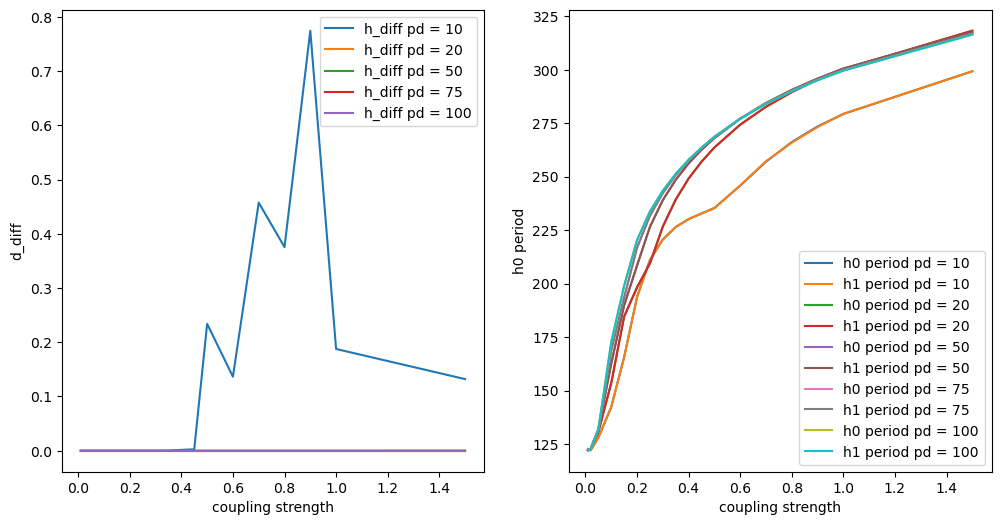

In [120]:
h_diff = np.zeros((len(p_ds), len(epsilons), 5000))
d_diff = np.zeros((len(p_ds), len(epsilons), 5000))

h_diff_mean = np.zeros((len(p_ds), len(epsilons)))
d_diff_mean = np.zeros((len(p_ds), len(epsilons)))
period_h0 = np.zeros((len(p_ds), len(epsilons)))
period_h1 = np.zeros((len(p_ds), len(epsilons)))
period_d0 = np.zeros((len(p_ds), len(epsilons)))
period_d1 = np.zeros((len(p_ds), len(epsilons)))

plt.figure(figsize=(12, 6))
for i in range(len(p_ds)):
    for j in range(len(epsilons)):
        h0 = results_hes_n[i,j,15000:,0,0]
        h1 = results_hes_n[i,j,15000:,0,1]
        d0 = results_hes_n[i,j,15000:,1,0] 
        d1 = results_hes_n[i,j,15000:,1,1]

        h_diff[i,j] = np.abs(h0 - h1)
        d_diff[i,j] = np.abs(d0 - d1)

        h_diff_mean[i,j] = np.mean(h_diff[i,j])
        d_diff_mean[i,j] = np.mean(d_diff[i,j])

        period_h0[i,j] = estimate_period_from_peaks(h0, time = np.arange(5000)*dt)[0]
        period_h1[i,j] = estimate_period_from_peaks(h1, time = np.arange(5000)*dt)[0]
        period_d0[i,j] = estimate_period_from_peaks(d0,time = np.arange(5000)*dt)[0]
        period_d1[i,j] = estimate_period_from_peaks(d1, time = np.arange(5000)*dt)[0]


    plt.subplot(1, 2, 1)
    plt.plot(epsilons, d_diff_mean[i,:], label='h_diff pd = {}'.format(p_ds[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('d_diff')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epsilons, period_h0[i,:], label='h0 period pd = {}'.format(p_ds[i]))
    plt.plot(epsilons, period_h1[i,:], label='h1 period pd = {}'.format(p_ds[i]))
    plt.xlabel('coupling strength')
    plt.ylabel('h0 period')
    plt.legend()

### Vary delay in coupling for Hes oscillating 2 cells

In [60]:
delay_coupling = [0, 2, 5, 10, 15, 20, 30, 40]
epsilons = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5]
n = 3
p_d = 50
w_coupling = 0.5

results_hes_delays = np.zeros((len(delay_coupling), len(epsilons), num_tsteps, 2, 2))

for i, T_coupling in enumerate(delay_coupling):
        for j, epsilon in enumerate(epsilons):
                params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, epsilon, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
                h, m_h, d, m_d = simulate(num_tsteps, dt, lattice, params, coupling_type= 'Delta', initial_type='uniform')

                print(i, T_coupling, j, epsilon)
                
                results_hes_delays[i,j,:,0,0] = h[:,0].flatten()
                results_hes_delays[i,j,:,0,1] = h[:,1].flatten()
                results_hes_delays[i,j,:,1,0] = d[:,0].flatten()
                results_hes_delays[i,j,:,1,1] = d[:,1].flatten()

100%|██████████| 19999/19999 [00:02<00:00, 7209.20it/s]


0 0 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 7041.91it/s]


0 0 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 7626.50it/s]


0 0 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 7836.90it/s]


0 0 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 7669.45it/s]


0 0 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 7918.44it/s]


0 0 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 8006.98it/s]


0 0 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 8126.36it/s]


0 0 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 7484.44it/s]


0 0 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 6907.71it/s]


0 0 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 7228.87it/s]


0 0 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 7116.96it/s]


0 0 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 7315.14it/s]


0 0 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 6843.48it/s]


0 0 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 7975.64it/s]


0 0 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 6963.31it/s]


0 0 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 7904.02it/s]


0 0 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 7807.83it/s]


0 0 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 7691.44it/s]


0 0 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 7405.96it/s]


0 0 19 2.5


100%|██████████| 19999/19999 [00:02<00:00, 6734.26it/s]


1 2 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 7213.57it/s]


1 2 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 7521.00it/s]


1 2 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 7710.00it/s]


1 2 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 7463.32it/s]


1 2 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 7820.17it/s]


1 2 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 7720.34it/s]


1 2 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 7856.48it/s]


1 2 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 7506.03it/s]


1 2 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 7935.05it/s]


1 2 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 7647.94it/s]


1 2 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 7789.98it/s]


1 2 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 7450.09it/s]


1 2 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 7782.47it/s]


1 2 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 7819.11it/s]


1 2 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 7723.96it/s]


1 2 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 7345.58it/s]


1 2 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 7897.95it/s]


1 2 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 7633.04it/s]


1 2 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 7466.47it/s]


1 2 19 2.5


100%|██████████| 19999/19999 [00:02<00:00, 7960.24it/s]


2 5 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 7604.06it/s]


2 5 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 7777.39it/s]


2 5 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 7749.73it/s]


2 5 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 7910.75it/s]


2 5 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 7881.09it/s]


2 5 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 8071.78it/s]


2 5 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 7745.51it/s]


2 5 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 7469.14it/s]


2 5 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 6732.14it/s]


2 5 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 6724.88it/s]


2 5 10 0.45


100%|██████████| 19999/19999 [00:03<00:00, 6143.03it/s]


2 5 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 6987.46it/s]


2 5 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 7455.34it/s]


2 5 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 7676.06it/s]


2 5 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 7743.96it/s]


2 5 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 7574.32it/s]


2 5 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 7825.97it/s]


2 5 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 7634.52it/s]


2 5 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 7637.16it/s]


2 5 19 2.5


100%|██████████| 19999/19999 [00:02<00:00, 7490.27it/s]


3 10 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 7855.03it/s]


3 10 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 7466.06it/s]


3 10 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 7786.72it/s]


3 10 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 7865.93it/s]


3 10 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 7607.19it/s]


3 10 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 7757.36it/s]


3 10 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 7321.93it/s]


3 10 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 7759.07it/s]


3 10 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 7967.41it/s]


3 10 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 7681.36it/s]


3 10 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 7910.79it/s]


3 10 11 0.5


100%|██████████| 19999/19999 [00:03<00:00, 6441.79it/s]


3 10 12 0.6


100%|██████████| 19999/19999 [00:03<00:00, 5868.73it/s]


3 10 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 6862.61it/s]


3 10 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 6830.19it/s]


3 10 15 0.9


100%|██████████| 19999/19999 [00:03<00:00, 6051.47it/s]


3 10 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 7597.22it/s]


3 10 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 7339.47it/s]


3 10 18 2.0


100%|██████████| 19999/19999 [00:03<00:00, 6379.38it/s]


3 10 19 2.5


100%|██████████| 19999/19999 [00:03<00:00, 5834.63it/s]


4 15 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 7461.61it/s]


4 15 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 8101.99it/s]


4 15 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 7854.96it/s]


4 15 3 0.1


100%|██████████| 19999/19999 [00:03<00:00, 5426.65it/s]


4 15 4 0.15


100%|██████████| 19999/19999 [00:04<00:00, 4946.33it/s]


4 15 5 0.2


100%|██████████| 19999/19999 [00:05<00:00, 3487.14it/s]


4 15 6 0.25


100%|██████████| 19999/19999 [00:03<00:00, 5552.34it/s]


4 15 7 0.3


100%|██████████| 19999/19999 [00:03<00:00, 6085.81it/s]


4 15 8 0.35


100%|██████████| 19999/19999 [00:03<00:00, 6664.74it/s]


4 15 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 6940.47it/s]


4 15 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 7527.61it/s]


4 15 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 7643.03it/s]


4 15 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 7747.26it/s]


4 15 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 7146.64it/s]


4 15 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 7590.54it/s]


4 15 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 7406.17it/s]


4 15 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 7746.38it/s]


4 15 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 7893.79it/s]


4 15 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 7382.94it/s]


4 15 19 2.5


100%|██████████| 19999/19999 [00:02<00:00, 7630.23it/s]


5 20 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 8127.05it/s]


5 20 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 8061.23it/s]


5 20 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 8031.93it/s]


5 20 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 8156.69it/s]


5 20 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 8097.04it/s]


5 20 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 8094.85it/s]


5 20 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 8055.12it/s]


5 20 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 8163.49it/s]


5 20 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 8083.43it/s]


5 20 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 8166.00it/s]


5 20 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 7996.75it/s]


5 20 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 7703.64it/s]


5 20 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 8171.37it/s]


5 20 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 8013.06it/s]


5 20 14 0.8


100%|██████████| 19999/19999 [00:03<00:00, 6081.92it/s]


5 20 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 8927.29it/s]


5 20 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 9346.75it/s]


5 20 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 9304.07it/s]


5 20 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 9276.30it/s]


5 20 19 2.5


100%|██████████| 19999/19999 [00:02<00:00, 9197.68it/s]


6 30 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 9304.01it/s]


6 30 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 9304.12it/s]


6 30 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 9233.23it/s]


6 30 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 9378.22it/s]


6 30 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 9231.90it/s]


6 30 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 9304.44it/s]


6 30 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 9117.74it/s]


6 30 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 9309.40it/s]


6 30 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 9405.99it/s]


6 30 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 9203.93it/s]


6 30 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 9088.45it/s]


6 30 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 9308.84it/s]


6 30 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 9184.81it/s]


6 30 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 9200.16it/s]


6 30 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 9280.55it/s]


6 30 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 9180.12it/s]


6 30 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 9380.14it/s]


6 30 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 9142.03it/s]


6 30 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 9291.48it/s]


6 30 19 2.5


100%|██████████| 19999/19999 [00:02<00:00, 9359.43it/s]


7 40 0 0.01


100%|██████████| 19999/19999 [00:02<00:00, 9085.13it/s]


7 40 1 0.02


100%|██████████| 19999/19999 [00:02<00:00, 9427.11it/s]


7 40 2 0.05


100%|██████████| 19999/19999 [00:02<00:00, 8734.73it/s]


7 40 3 0.1


100%|██████████| 19999/19999 [00:02<00:00, 9212.88it/s]


7 40 4 0.15


100%|██████████| 19999/19999 [00:02<00:00, 9268.51it/s]


7 40 5 0.2


100%|██████████| 19999/19999 [00:02<00:00, 9143.08it/s]


7 40 6 0.25


100%|██████████| 19999/19999 [00:02<00:00, 9291.80it/s]


7 40 7 0.3


100%|██████████| 19999/19999 [00:02<00:00, 9251.50it/s]


7 40 8 0.35


100%|██████████| 19999/19999 [00:02<00:00, 9430.34it/s]


7 40 9 0.4


100%|██████████| 19999/19999 [00:02<00:00, 9400.58it/s]


7 40 10 0.45


100%|██████████| 19999/19999 [00:02<00:00, 9339.84it/s]


7 40 11 0.5


100%|██████████| 19999/19999 [00:02<00:00, 9448.27it/s]


7 40 12 0.6


100%|██████████| 19999/19999 [00:02<00:00, 9333.97it/s]


7 40 13 0.7


100%|██████████| 19999/19999 [00:02<00:00, 9067.05it/s]


7 40 14 0.8


100%|██████████| 19999/19999 [00:02<00:00, 6720.85it/s]


7 40 15 0.9


100%|██████████| 19999/19999 [00:02<00:00, 7238.30it/s]


7 40 16 1.0


100%|██████████| 19999/19999 [00:02<00:00, 7881.28it/s]


7 40 17 1.5


100%|██████████| 19999/19999 [00:02<00:00, 8813.36it/s]


7 40 18 2.0


100%|██████████| 19999/19999 [00:02<00:00, 8827.23it/s]

7 40 19 2.5


In [71]:
# Get 20 colors from the viridis colormap
viridis = plt.cm.get_cmap('viridis', 20)
colors = [viridis(i) for i in range(20)]


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_20452\1209775591.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap('viridis', 20)


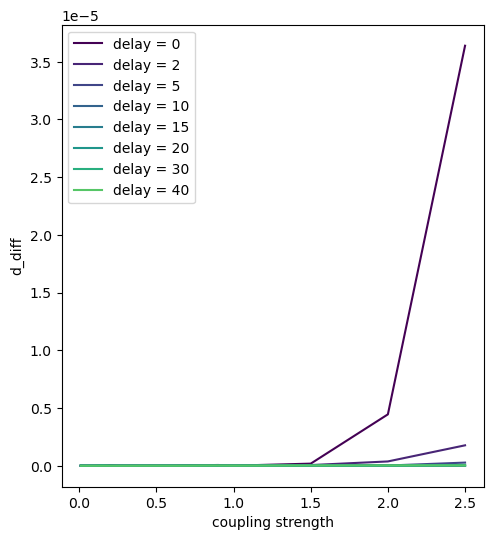

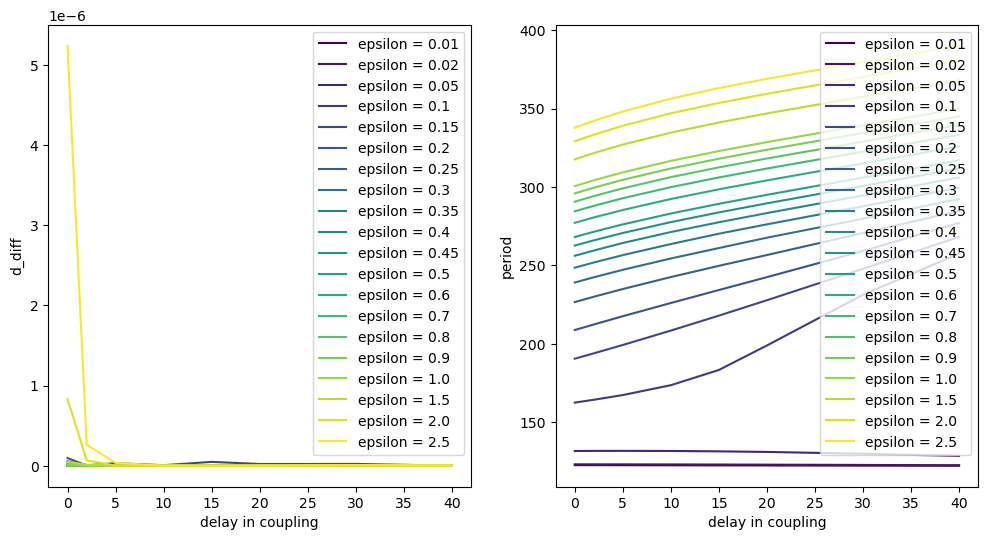

In [74]:
h_diff = np.zeros((len(delay_coupling), len(epsilons), num_tsteps - time_start))
d_diff = np.zeros((len(delay_coupling), len(epsilons), num_tsteps - time_start))

h_diff_mean = np.zeros((len(delay_coupling), len(epsilons)))
d_diff_mean = np.zeros((len(delay_coupling), len(epsilons)))

period_h0 = np.zeros((len(delay_coupling), len(epsilons)))
period_h1 = np.zeros((len(delay_coupling), len(epsilons)))
period_d0 = np.zeros((len(delay_coupling), len(epsilons)))
period_d1 = np.zeros((len(delay_coupling), len(epsilons)))


plt.figure(figsize=(12, 6))
for i in range(len(delay_coupling)):
    for j in range (len(epsilons)):

        h0 = results_hes_delays[i,j, time_start:,0,0]
        h1 = results_hes_delays[i,j,time_start:,0,1]
        d0 = results_hes_delays[i,j,time_start:,1,0] 
        d1 = results_hes_delays[i,j, time_start:,1,1]

        h_diff[i,j] = np.abs(h0 - h1)
        d_diff[i,j] = np.abs(d0 - d1)

        h_diff_mean[i,j] = np.mean(h_diff[i,j])
        d_diff_mean[i,j] = np.mean(d_diff[i,j])

        period_h0[i,j] = estimate_period_from_peaks(h0, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_h1[i,j] = estimate_period_from_peaks(h1, time = np.arange(num_tsteps-time_start)*dt)[0]
        period_d0[i,j] = estimate_period_from_peaks(d0,time = np.arange(num_tsteps-time_start)*dt)[0]
        period_d1[i,j] = estimate_period_from_peaks(d1, time = np.arange(num_tsteps-time_start)*dt)[0]


plt.subplot(1, 2, 1)
for i in range(len(delay_coupling)):
    plt.plot(epsilons, h_diff_mean[i,:], label='delay = {}'.format(delay_coupling[i]), color=colors[2*i])
    plt.xlabel('coupling strength')
    plt.ylabel('d_diff')
    plt.legend()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for j in range(len(epsilons)):
    plt.plot(delay_coupling, d_diff_mean[:,j], label='epsilon = {}'.format(epsilons[j]), color=colors[j])
    plt.xlabel('delay in coupling')
    plt.ylabel('d_diff')
    plt.legend()


plt.subplot(1, 2, 2)
for j in range(len(epsilons)):
    plt.plot(delay_coupling, period_h0[:,j], label='epsilon = {}'.format(epsilons[j]), color=colors[j])
    plt.xlabel('delay in coupling')
    plt.ylabel('period')
    plt.legend()


## A single cell in a fixed Delta environment

In [126]:
def evaluate_fixed_delta(num_tsteps, dt, external_delta, lattice, params):
    h_init, m_h_init, d_init, m_d_init = get_initial(lattice, params, initial_type = 'checkerboard', initial_val2=300)
    h_init, m_h_init, d_init, m_d_init = get_initial(lattice, params, initial_type = 'uniform')

    #intrinsic oscillator components
    h = np.zeros([num_tsteps, lattice.P, lattice.Q])
    m_h = np.zeros([num_tsteps, lattice.P, lattice.Q])
    d = np.zeros([num_tsteps, lattice.P, lattice.Q])
    m_d = np.zeros([num_tsteps, lattice.P, lattice.Q])

    h[0] = h_init
    m_h[0] = m_h_init
    d[0] = d_init
    m_d[0] = m_d_init

    # iterate through the time steps and calculate the values of the next time step
    for i in tqdm(range(int(num_tsteps-1))):

        # calculate delayed values of Hes
        params.T_h_steps = np.round(params.T_h / dt).astype(int)
        h_delay = get_delayed_value(h, i, params.T_h_steps, lattice, params)

        d[i+1,:,:] = Euler(d[i,:,:], dd_dt(d[i,:,:], m_d[i,:,:], params), dt)
        m_d[i+1,:,:] = Euler(m_d[i,:,:], dmd_dt(m_d[i,:,:], h_delay[i,:,:], params), dt)

        couple_component = external_delta/w_coupling
        
        # calculate the values of the next time step for Hes and Hes mRNA
        h[i+1,:,:] = Euler(h[i,:,:], dh_dt(h[i,:,:], m_h[i,:,:], params), dt)
        m_h[i+1,:,:] = Euler(m_h[i,:,:], dmh_dt(m_h[i,:,:], h_delay[i,:,:], couple_component, params, lattice), dt)

    return h, m_h, d, m_d

In [127]:
#set the lattice of the cells 
P = 3
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.5
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)


num_tsteps = 20000
dt = 0.2

namespace(gamma_h=0.03, gamma_d=0.03, gamma_m=0.03, p_h=100, p_d=50, T_h=array([20., 20., 20.]), T_coupling=array([0., 0., 0.]), w_h=1, w_coupling=0.5, l=5, n=3, grad_hes=False, grad_coup=False, grad_hes_strength=0.2, grad_coup_strength=0)


In [128]:
delta_fixed = np.linspace(0, 0.1, 26)
results_fixed = np.zeros((len(delta_fixed), num_tsteps, 2))

for i, delta in enumerate(delta_fixed):
    h, m_h, d, m_d = evaluate_fixed_delta(num_tsteps, dt, delta, lattice, params)

    print(i, delta)
    
    results_fixed[i,:,0] = h[:,1].flatten()
    results_fixed[i,:,1] = d[:,1].flatten()


100%|██████████| 19999/19999 [00:01<00:00, 11749.97it/s]


0 0.0


100%|██████████| 19999/19999 [00:01<00:00, 12818.41it/s]


1 0.004


100%|██████████| 19999/19999 [00:01<00:00, 11254.82it/s]


2 0.008


100%|██████████| 19999/19999 [00:01<00:00, 11300.77it/s]


3 0.012


100%|██████████| 19999/19999 [00:01<00:00, 13676.01it/s]


4 0.016


100%|██████████| 19999/19999 [00:01<00:00, 10693.81it/s]


5 0.02


100%|██████████| 19999/19999 [00:01<00:00, 12447.28it/s]


6 0.024


100%|██████████| 19999/19999 [00:02<00:00, 9699.74it/s] 


7 0.028


100%|██████████| 19999/19999 [00:01<00:00, 12819.11it/s]


8 0.032


100%|██████████| 19999/19999 [00:01<00:00, 12535.36it/s]


9 0.036000000000000004


100%|██████████| 19999/19999 [00:01<00:00, 11641.65it/s]


10 0.04


100%|██████████| 19999/19999 [00:01<00:00, 10858.51it/s]


11 0.044


100%|██████████| 19999/19999 [00:01<00:00, 11056.46it/s]


12 0.048


100%|██████████| 19999/19999 [00:01<00:00, 11174.89it/s]


13 0.052000000000000005


100%|██████████| 19999/19999 [00:02<00:00, 9198.39it/s] 


14 0.056


100%|██████████| 19999/19999 [00:01<00:00, 12092.99it/s]


15 0.06


100%|██████████| 19999/19999 [00:01<00:00, 12650.07it/s]


16 0.064


100%|██████████| 19999/19999 [00:01<00:00, 13470.66it/s]


17 0.068


100%|██████████| 19999/19999 [00:01<00:00, 12127.88it/s]


18 0.07200000000000001


100%|██████████| 19999/19999 [00:01<00:00, 12814.96it/s]


19 0.076


100%|██████████| 19999/19999 [00:01<00:00, 12799.76it/s]


20 0.08


100%|██████████| 19999/19999 [00:02<00:00, 9691.64it/s] 


21 0.084


100%|██████████| 19999/19999 [00:01<00:00, 11303.61it/s]


22 0.088


100%|██████████| 19999/19999 [00:01<00:00, 12659.04it/s]


23 0.092


100%|██████████| 19999/19999 [00:01<00:00, 12725.54it/s]


24 0.096


100%|██████████| 19999/19999 [00:02<00:00, 8295.62it/s]

25 0.1


(26,)
[4.13413449e+01 3.33607638e+01 2.43004406e+01 1.44161954e+01
 6.36671310e+00 2.27753887e+00 7.92066131e-01 2.63444735e-01
 8.34678059e-02 2.66826920e-02 8.09694481e-03 3.10306307e-03
 9.24666510e-04 2.77020693e-04 7.72831880e-05 3.15817544e-05
 8.74514175e-06 2.25858349e-06 9.71413414e-07 2.92870865e-07
 8.28607867e-08 4.17488479e-08 1.09941851e-08 2.96900282e-09
 1.70614101e-09 4.25050217e-10]


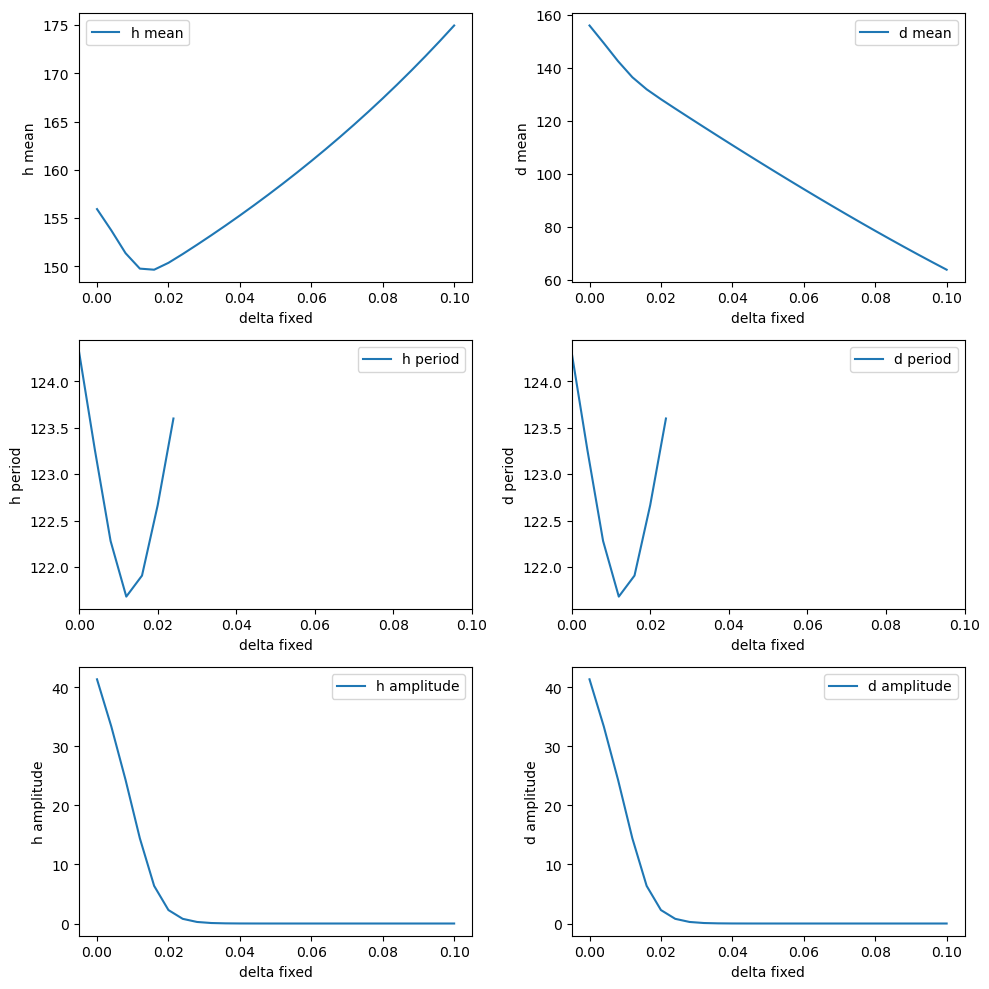

In [125]:
start_time = 10000

h_mean = np.mean(results_fixed[:,start_time:,0], axis=1)
d_mean = np.mean(results_fixed[:,start_time:,1], axis=1)

amplitude_h = np.zeros(len(delta_fixed))
amplitude_d = np.zeros(len(delta_fixed))
period_h = np.zeros(len(delta_fixed))
period_d = np.zeros(len(delta_fixed))

for i in range(len(delta_fixed)):
    amplitude_h[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,0])[0]
    amplitude_d[i] = estimate_amplitude_from_peaks(results_fixed[i,start_time:,1])[0]

    amplitude_d = np.nan_to_num(amplitude_d, nan=0.0)  # Handle NaN values
    amplitude_h = np.nan_to_num(amplitude_h, nan=0.0)  # Handle NaN values

    if amplitude_h[i] > 0.5:
        period_h[i] = estimate_period_from_peaks(results_fixed[i,start_time:,0], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_h[i] = None

    if amplitude_d[i] > 0.5:
        period_d[i] = estimate_period_from_peaks(results_fixed[i,start_time:,1], time = np.arange(num_tsteps-start_time)*dt)[0]
    else:
        period_d[i] = None

print(amplitude_h.shape)
print(amplitude_d)

plt.figure(figsize=(10, 10))
plt.subplot(3, 2, 1)
plt.plot(delta_fixed, h_mean, label='h mean')
plt.xlabel('delta fixed')
plt.ylabel('h mean')   
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(delta_fixed, d_mean, label='d mean')
plt.xlabel('delta fixed')
plt.ylabel('d mean')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(delta_fixed, period_h, label='h period')
plt.xlabel('delta fixed')
plt.xlim(0, max(delta_fixed))
plt.ylabel('h period')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(delta_fixed, period_d, label='d period')
plt.xlabel('delta fixed')
plt.xlim(0, max(delta_fixed))
plt.ylabel('d period')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(delta_fixed, amplitude_h, label='h amplitude')
plt.xlabel('delta fixed')
plt.ylabel('h amplitude')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(delta_fixed, amplitude_d, label='d amplitude')
plt.xlabel('delta fixed')
plt.ylabel('d amplitude')
plt.legend()
plt.tight_layout()

## Synchronicity between two cells

In [ ]:
#set the lattice of the cells 
P = 2
Q = 1

lattice = get_lattice(P, Q)

# set initial parameters of the reactions 
gamma_h = 0.03
gamma_d = 0.03
gamma_m = 0.03
p_h = 100
p_d = 50
T_h = 20
T_coupling = 0
w_h = 1
w_coupling = 0.2
l = 5
n = 3

params = get_params(gamma_h, gamma_d, gamma_m, p_h, p_d, T_h, T_coupling, w_h, w_coupling, l, n, lattice, grad_hes = False, grad_coup = False, grad_hes_strength = 0.2, grad_coup_strength = 0)
print(params)

num_tsteps = 20000
dt = 0.2